# 构建CART树
## 目录

## CART树简介
使用最为广泛的决策树，同时也是sklearn中使用的  
CART树在原本C4.5的基础上进一步改进，将所有的特征属性都是二分类，最终构成一棵二叉树

## 实现CART树

In [12]:
import numpy as np
import pandas as pd
from collections import Counter
from graphviz import Digraph
import graphviz
class Decision_tree():
    
    def __init__(self,cal = "Entropy"):
        self.tree = None
        self.cal = cal
        self.columns=None
    
    def calEnt(self,y):
        count = Counter(y)
        p = np.array(list(count.values()))/len(y)
        Ent = (-p* np.log2(p)).sum()
        return Ent
    
    def calGini(self,y):
        count = Counter(y)
        p = np.array(list(count.values()))/len(y)
        Gini = 1-(p**2).sum()
        return Gini
    
    def calimpurity(self,y):
        """根据参数来选择是使用Entropy还是Gini来计算不纯度"""
        if self.cal == "Entropy":
            return self.calEnt(y)
        else:
            return self.calGini(y)
        
    def fit_CART(self,X,y,featurename):
        
        def bestsplit(X,y):
            """以信息增益率为依据，让数据集根据某一个特征值进行划分，返回数据集最佳切分列索引和切分值"""
            bestFeature = -1
            bestGainRatio = -1
            bestsplitvalue = -1
            baseEnt = self.calimpurity(y)
            
            for i in range(X.shape[1]):
                if len(list(Counter(X[:,i]))) == 1:
                    continue
                sort_index = np.argsort(X[:,i])
                for j in range(1,len(X)):
                    if X[sort_index[j-1],i] != X[sort_index[j],i]:
                        splitvalue = (X[sort_index[j-1],i]+X[sort_index[j],i])/2
                        y_l = y[X[:,i] < splitvalue]
                        y_r = y[X[:,i] >= splitvalue]
                        
                        inforGain = baseEnt - (len(y_l)/len(y)*self.calimpurity(y_l)+len(y_r)/len(y)*self.calimpurity(y_r))
                        inforValuetemp = np.array([len(y_l)/len(y),len(y_r)/len(y)])
                        inforValue = np.sum(-inforValuetemp*np.log2(inforValuetemp))
                        
                        GainRatio = inforGain/inforValue
                        if GainRatio > bestGainRatio:
                            bestGainRatio = GainRatio
                            bestFeature = i
                            bestsplitvalue = splitvalue
            return bestFeature,bestsplitvalue
            
        def splitData(X,y,bestFeature,bestSplit):
            """按指定的特征和标签来划分数据子集"""
            subX_l = X[X[:,bestFeature] < bestSplit]
            suby_l = y[X[:,bestFeature] < bestSplit]
            subX_r = X[X[:,bestFeature] >= bestSplit]
            suby_r = y[X[:,bestFeature] >= bestSplit]
            return subX_l,subX_r,suby_l,suby_r
        
        def countvalidfeature(X):
            cal = 0
            for i in range(X.shape[1]):
                if len(list(Counter(X[:,i])))!=1:
                    cal +=1
            return cal
        
        def createTree(X,y,featurename):
            """用字典的形式保存最终的树"""
            if countvalidfeature(X) == 1 or len(list(Counter(y)))==1:#即没有再可以划分的特征，或者子集已经只有一列，则迭代结束
                return Counter(y).most_common(1)[0][0]#返回所占比例最多的类别
            
            bestFeature,bestsplitvalue = bestsplit(X,y)
            bestfeaturename = featurename[bestFeature]
            dic = {}
            subX_l,subX_r,suby_l,suby_r = splitData(X,y,bestFeature,bestsplitvalue)
            dic["<{}".format(bestsplitvalue)] = createTree(subX_l,suby_l,featurename)
            dic[">={}".format(bestsplitvalue)] = createTree(subX_r,suby_r,featurename)
            
            mytree = {bestfeaturename:dic}
            return mytree
         
        self.columns = featurename    
        self.tree = createTree(X,y,featurename)
        return self
        
        
    def _predict(self,test):
        """对单条测试集进行预测"""

        def __predict(tree,test,columns):
            feature = next(iter(tree))
            secondDic = tree[feature]
            index = columns.index(feature)
            content = test[index]
            for key in secondDic:
                try:
                    if eval(str(content)+key):
                        if type(secondDic[key]) == dict :
                            return __predict(secondDic[key],test,columns)
                        else:
                            return secondDic[key]
                except:
                    print(str(content)+key)

        assert self.tree is not None,"fit before predict"
        tree = self.tree
        columns = self.columns
        return __predict(tree,test,columns)
    
    def predict(self,X_test):
        return np.array([self._predict(test) for test in X_test])
            
    def score(self,X_test,y_test):
        """计算模型的准确率"""
        y_predict = self.predict(X_test)
        return (y_test == y_predict).mean()
    
    def draw_tree(self):
        from graphviz import Digraph
        
        def export_graphviz(tree,root_index): 
            root = next(iter(tree))
            text_node.append([str(root_index),root])
            secondDic = tree[root]
            for key in secondDic:
                if type(secondDic[key]) == dict:
                    i[0] += 1
                    secondrootindex=i[0]
                    text_edge.append([str(root_index),str(secondrootindex),str(key)])
                    export_graphviz(secondDic[key],secondrootindex)
                else:
                    i[0] += 1
                    text_node.append([str(i[0]),str(secondDic[key])])
                    text_edge.append([ str(root_index) , str(i[0]) , str(key) ])
          
        
        tree = self.tree
        text_node=[]
        text_edge=[]
        i=[1]
        export_graphviz(tree,i[0])
        dot = Digraph()
        for line in text_node:
            dot.node(line[0],line[1])
        for line in text_edge:
            dot.edge(line[0],line[1],line[2])
        
        dot.view()

## 用数据集检验实现的CART树

In [2]:
data = pd.DataFrame([
    [29,0,0,0,"no"],
    [28,0,0,1,"no"],
    [34,0,0,0,"yes"],
    [45,1,0,0,"yes"],
    [56,2,1,0,"yes"],
    [67,2,1,1,"no"],
    [35,2,1,1,"yes"],
    [29,1,0,0,"no"],
    [29,2,1,0,"yes"],
    [54,1,1,0,"yes"],
    [18,1,1,1,"yes"],
    [32,1,0,1,"yes"],
    [33,0,1,0,"yes"],
    [45,1,0,1,"no"]
                 ],columns=["age","income","student","credit_rating","Class"])
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
#high=0,medium=1,low=2
#fair=0,excellent=1

In [3]:
clf = Decision_tree()
clf.fit_CART(np.array(X),np.array(y),list(X.columns))

In [4]:
clf.tree

{'age': {'<61.5': {'student': {'<0.5': {'age': {'<30.5': 'no',
      '>=30.5': {'age': {'<39.5': 'yes', '>=39.5': 'yes'}}}},
    '>=0.5': 'yes'}},
  '>=61.5': 'no'}}

In [5]:
clf.draw_tree()

## 用红酒数据集与sklearn中的CART树进行性能上的对比（未剪枝的前提下）

In [13]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
wine = load_wine()
X = wine.data
y = wine.target
col = wine.feature_names
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [14]:
%time
clf = Decision_tree()
clf.fit_CART(X_train,y_train,col)
clf.score(X_test,y_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 22.9 µs


0.9555555555555556

In [15]:
clf.draw_tree()

In [16]:
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz

In [17]:
%time
clf_sklearn = DecisionTreeClassifier(criterion="entropy")
clf_sklearn.fit(X_train,y_train)
clf_sklearn.score(X_test,y_test)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11 µs


0.9111111111111111

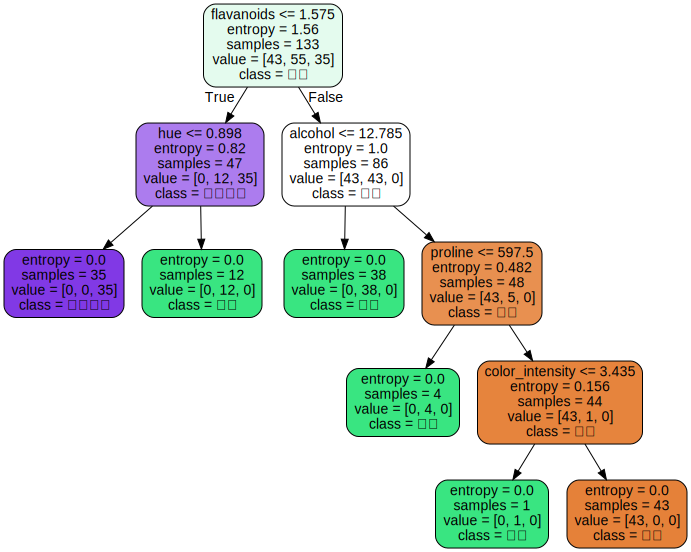

In [18]:
dot_data = export_graphviz(clf_sklearn,
                            feature_names=wine.feature_names,
                            class_names=['琴酒','雪梨','贝尔摩德'],
                            rounded=True,
                            filled=True)
graph = graphviz.Source(dot_data)
graph

总结：  
自己实现的CART树的代码和sklearn中的CART的代码，在未进行剪枝时，两者在准确度上和时间复杂度上都差不多。  
甚至自己实现的CART树还有点小优势  
但估计当特征数较多时，自己实现的CART树的优势就不大了，因为sklearn采用的是随机建树，降低过拟合的程度